In [4]:
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pyproj
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs

# OSGB is also called "OSGB 1936 / British National Grid -- United
# Kingdom Ordnance Survey".  OSGB is used in many UK electricity
# system maps, and is used by the UK Met Office UKV model.  OSGB is a
# Transverse Mercator projection, using 'easting' and 'northing'
# coordinates which are in meters.  See https://epsg.io/27700
OSGB_EPSG = 27700

# WGS84 is short for "World Geodetic System 1984", used in GPS. Uses
# latitude and longitude.
WGS84_EPSG = 4326


plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['figure.facecolor'] = 'white'

PV_PATH = Path("/mnt/storage_b/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/PV/Passiv/ocf_formatted/v0")
PV_DATA_PATH = PV_PATH / "passiv.netcdf"
PV_METADATA_PATH = PV_PATH / "system_metadata_OCF_ONLY.csv"

NWP_ZARR_PATH = Path("/mnt/storage_ssd_8tb/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/NWP/UK_Met_Office/UKV/zarr/UKV_intermediate_version_3.zarr")

## Open and prepare PV data

In [2]:
pv_data = xr.open_dataset(PV_DATA_PATH)
pv_metadata = (
    pd.read_csv(PV_METADATA_PATH, index_col="system_id")
    .drop(columns=["Unnamed: 0", "ss_id", "llsoacd"])
)

In [5]:
pv_metadata = gpd.GeoDataFrame(
    pv_metadata,
    geometry=gpd.points_from_xy(pv_metadata.longitude, pv_metadata.latitude, crs=WGS84_EPSG)
)

In [6]:
all_pv_system_ids = [
    int(system_id) for system_id in list(pv_data.variables.keys())
    if system_id != "datetime"
]

# Remove "day behind" PV systems from metadata:

all_pv_system_ids = pv_metadata.index.intersection(all_pv_system_ids)
pv_metadata = pv_metadata.loc[all_pv_system_ids]

In [43]:
# 1 has good data but very little shading (maybe just a tiny bit in the late-afternoon?)
# 3 has good data, and I think has more shading that 1 (in the morning)
# 5 has most shading so far
# 7 has no shading
# 8 has lots of shading
# 12 has no shading
# 13 has lots of shading!

pv_system_id = all_pv_system_ids[13]
pv_system_id

2766

In [8]:
# Find the nearest N PV systems to pv_system_id
point = pv_metadata.loc[pv_system_id].geometry
pv_metadata["distance"] = pv_metadata.apply(lambda row: point.distance(row.geometry), axis=1)

In [9]:
nearby_pv_systems = pv_metadata.sort_values("distance").iloc[1:11]
nearby_pv_systems

,orientation,tilt,kwp,operational_at,latitude,longitude,geometry,distance
system_id,,,,,,,,
17465,180.0,55.0,4.00,2015-07-16,55.891193,-4.890903,POINT (-4.89090 55.89119),0.089226
3872,135.0,40.0,3.99,2012-02-20,55.890190,-4.897210,POINT (-4.89721 55.89019),0.090607
10512,250.0,35.0,2.50,2014-06-03,55.953359,-4.819659,POINT (-4.81966 55.95336),0.152017
11828,208.0,33.0,2.50,2014-09-26,55.654983,-4.808111,POINT (-4.80811 55.65498),0.161074
7390,180.0,35.0,3.06,2013-04-02,55.940140,-4.769610,POINT (-4.76961 55.94014),0.161458
11895,170.0,36.0,2.00,2014-11-13,55.958428,-4.794455,POINT (-4.79445 55.95843),0.165352
13500,168.0,36.0,2.50,2014-12-03,55.703895,-4.730323,POINT (-4.73032 55.70390),0.166582
7700,146.0,30.0,2.50,2013-08-08,55.703009,-4.727332,POINT (-4.72733 55.70301),0.169482
7066,135.0,30.0,3.92,2012-12-15,55.651491,-4.790962,POINT (-4.79096 55.65149),0.170676


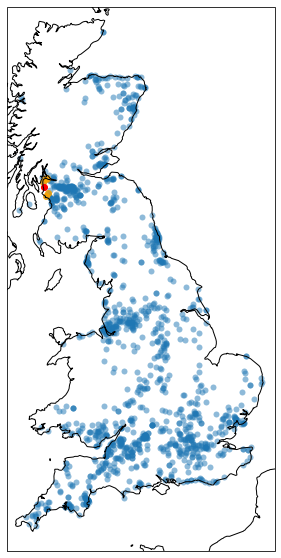

In [11]:
# Plot all PV systems, and PV system of interest, and nearby PV systems
ax = plt.axes(projection=ccrs.PlateCarree())
pv_metadata.plot(ax=ax, alpha=0.5, linewidth=0)
nearby_pv_systems.plot(ax=ax, alpha=0.5, color="orange")
ax.scatter(
    *pv_metadata.loc[pv_system_id][["longitude", "latitude"]], 
    color="red")
ax.coastlines();

In [35]:
pv_data_for_single_system = pv_data[str(pv_system_id)].to_pandas().dropna()
pv_data_for_nearby_systems = pd.concat(
    [
        pv_data[str(nearby_pv_system_id)].to_pandas().dropna().rename(nearby_pv_system_id)
        for nearby_pv_system_id in nearby_pv_systems.index
    ],
    axis="columns"
    )

In [36]:
pv_data_for_single_system.index[0], pv_data_for_single_system.index[-1]

(Timestamp('2018-01-01 06:05:00'), Timestamp('2021-10-27 23:55:00'))

In [37]:
pv_data_for_nearby_systems

,17465,3872,10512,11828,7390,11895,13500,7700,7066,11174
datetime,,,,,,,,,,
2018-01-01 06:05:00,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
2018-01-01 06:10:00,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
2018-01-01 06:15:00,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
2018-01-01 06:20:00,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
2018-01-01 06:25:00,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-10-27 23:35:00,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN
2021-10-27 23:40:00,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN
2021-10-27 23:45:00,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN


/tmp/ipykernel_34949/204571188.py:10: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  pv_data_for_nearby_systems.loc[DATE].rolling("60min").mean() / pv_data_for_nearby_systems[DATE].max(),


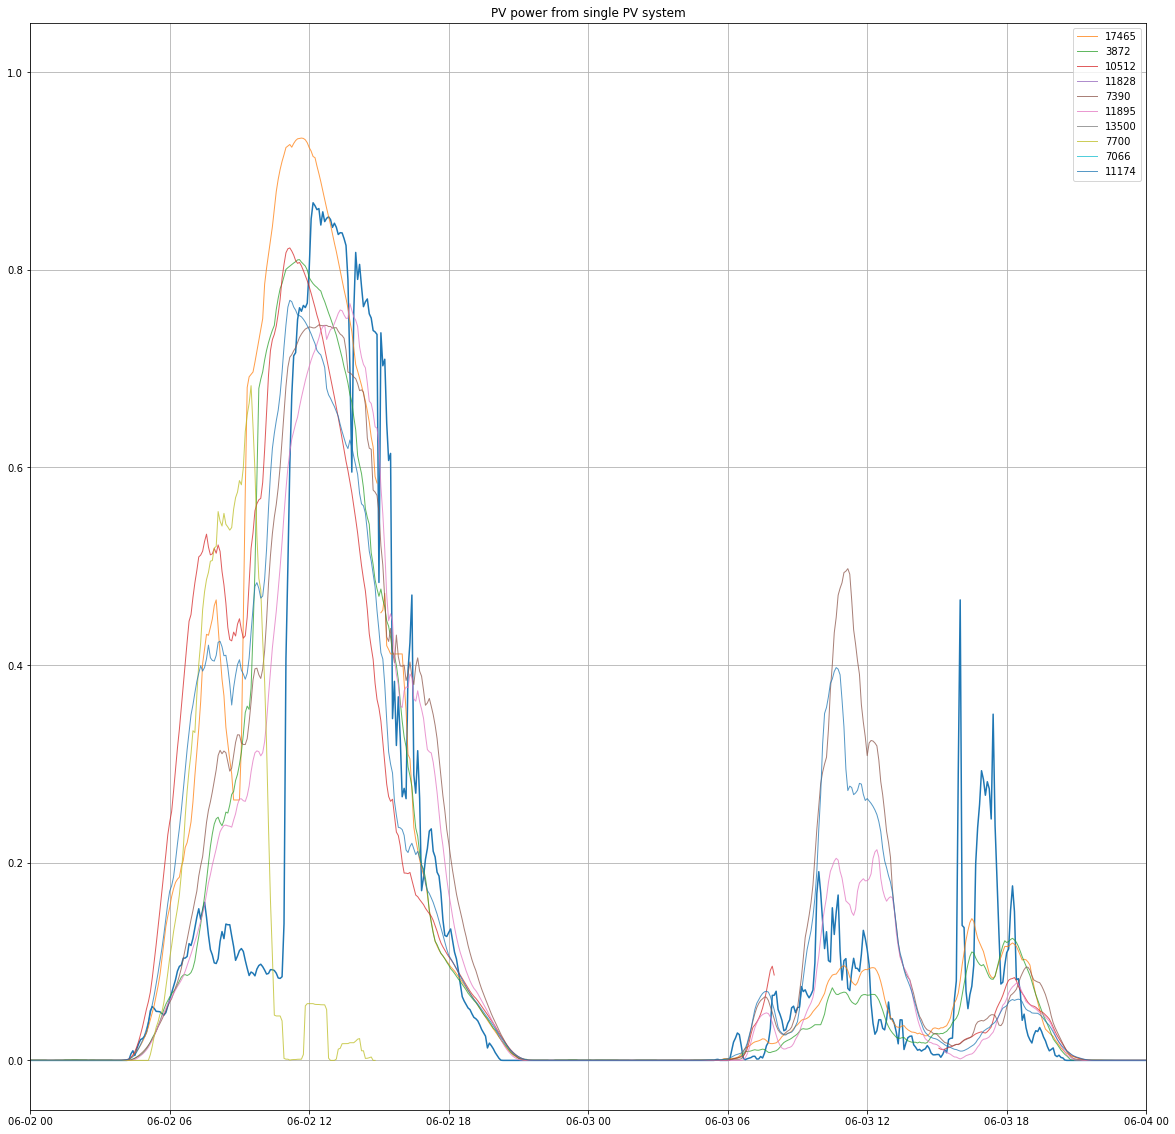

In [80]:
DATE = "2021-06"

fig, ax = plt.subplots(figsize=(20, 20))

ax.plot(pv_data_for_single_system[DATE] / pv_data_for_single_system[DATE].max())
ax.set_title("PV power from single PV system")


ax.plot(
    pv_data_for_nearby_systems.loc[DATE].rolling("60min").mean() / pv_data_for_nearby_systems[DATE].max(), 
    linewidth=1, 
    alpha=0.75,
    label=[str(pv_id) for pv_id in pv_data_for_nearby_systems.columns],
)
ax.legend()

ax.set_xlim(
    mdates.datestr2num("2021-06-02"),
    mdates.datestr2num("2021-06-04")
)
ax.grid();

In [44]:
data_for_plot = pv_data_for_single_system[pv_data_for_single_system.index.month == 7].to_frame("power")
data_for_plot["hour_of_day"] = data_for_plot.index.hour + (data_for_plot.index.minute / 60)

In [45]:
data_for_plot_pivotted = data_for_plot.pivot_table(
    index="hour_of_day",
    columns=data_for_plot.index.date,
    values="power",
)

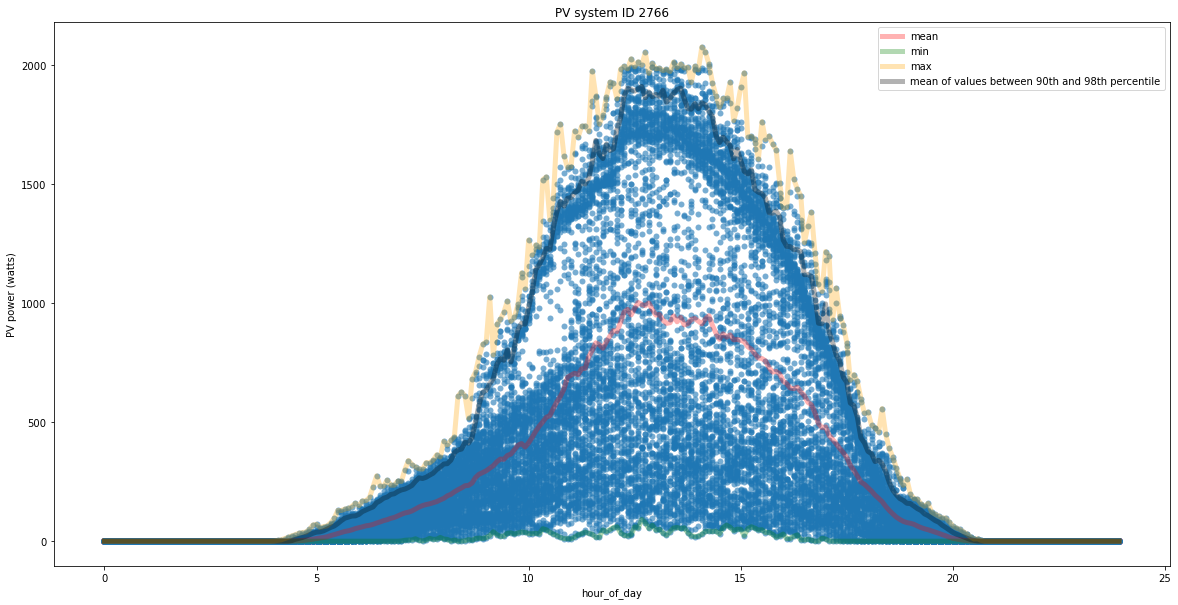

In [46]:
fig, ax = plt.subplots()
ax.scatter(
    x=data_for_plot["hour_of_day"],
    y=data_for_plot["power"],
    alpha=0.6,
    linewidths=0
)
line_plot_kwargs = dict(ax=ax, linewidth=5, alpha=0.3)
data_for_plot_pivotted.mean(axis="columns").plot(color="red", label="mean", **line_plot_kwargs)
data_for_plot_pivotted.min(axis="columns").plot(color="green", label="min", **line_plot_kwargs)
data_for_plot_pivotted.max(axis="columns").plot(color="orange", label="max", **line_plot_kwargs)

data_for_plot_pivotted[
    data_for_plot_pivotted.ge(data_for_plot_pivotted.quantile(q=0.90, axis="columns"), axis="index") &
    data_for_plot_pivotted.le(data_for_plot_pivotted.quantile(q=0.98, axis="columns"), axis="index")
].mean(axis="columns").plot(color="black", label="mean of values between 90th and 98th percentile", **line_plot_kwargs)

ax.set_title(f"PV system ID {pv_system_id}")
ax.set_ylabel("PV power (watts)")

ax.legend();

## pvlib

See [this StackOverflow answer for how to use pvlib for "generic" PV systems](https://stackoverflow.com/a/57169613/732596).

In [47]:
from pvlib import pvsystem, location, modelchain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

In [48]:
metadata_for_pv_system = pv_metadata.loc[pv_system_id]
metadata_for_pv_system

orientation                                              185.0
tilt                                                      30.0
kwp                                                       2.25
operational_at                                      2011-09-16
latitude                                             55.807096
longitude                                            -4.861087
geometry          POINT (-4.861086566736806 55.80709595696567)
distance                                                   0.0
Name: 2766, dtype: object

In [49]:
power_watts = max(
    pv_data_for_single_system.max(),
    metadata_for_pv_system.kwp * 1000,
)

module_parameters = dict(
    pdc0=power_watts,
    gamma_pdc=-0.004,  # from https://pvlib-python.readthedocs.io/en/stable/pvsystem.html
)

inverter_parameters = dict(
    pdc0=power_watts,
    # eta_inv_norm=0.96,  # from https://pvlib-python.readthedocs.io/en/stable/pvsystem.html
)

In [50]:
power_watts

2250.0

In [51]:
pv_system = pvsystem.PVSystem(
    surface_tilt=metadata_for_pv_system["tilt"],
    surface_azimuth=metadata_for_pv_system["orientation"],
    module_parameters=module_parameters,
    inverter_parameters=inverter_parameters,
    temperature_model_parameters=TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass'] # from: https://pvlib-python.readthedocs.io/en/stable/forecasts.html#pv-power-forecast
)
pv_system

PVSystem:
  name: None
  Array:
    name: None
    mount: FixedMount(surface_tilt=30.0, surface_azimuth=185.0, racking_model=None, module_height=None)
    module: None
    albedo: 0.25
    module_type: None
    temperature_model_parameters: {'a': -3.47, 'b': -0.0594, 'deltaT': 3}
    strings: 1
    modules_per_string: 1
  inverter: None

In [52]:
pv_location = location.Location(
    latitude=metadata_for_pv_system.latitude,
    longitude=metadata_for_pv_system.longitude,
    tz="Europe/London",
)
pv_location

Location: 
  name: None
  latitude: 55.80709595696567
  longitude: -4.861086566736806
  altitude: 0
  tz: Europe/London

In [53]:
model_chain = modelchain.ModelChain(
    system=pv_system,
    location=pv_location,
    dc_model="pvwatts",
    aoi_model="no_loss",
    spectral_model="no_loss",
)

In [54]:
pv_data_to_forecast = pv_data_for_single_system["2021-06"]

clearsky = pv_location.get_clearsky(times=pv_data_to_forecast.index)

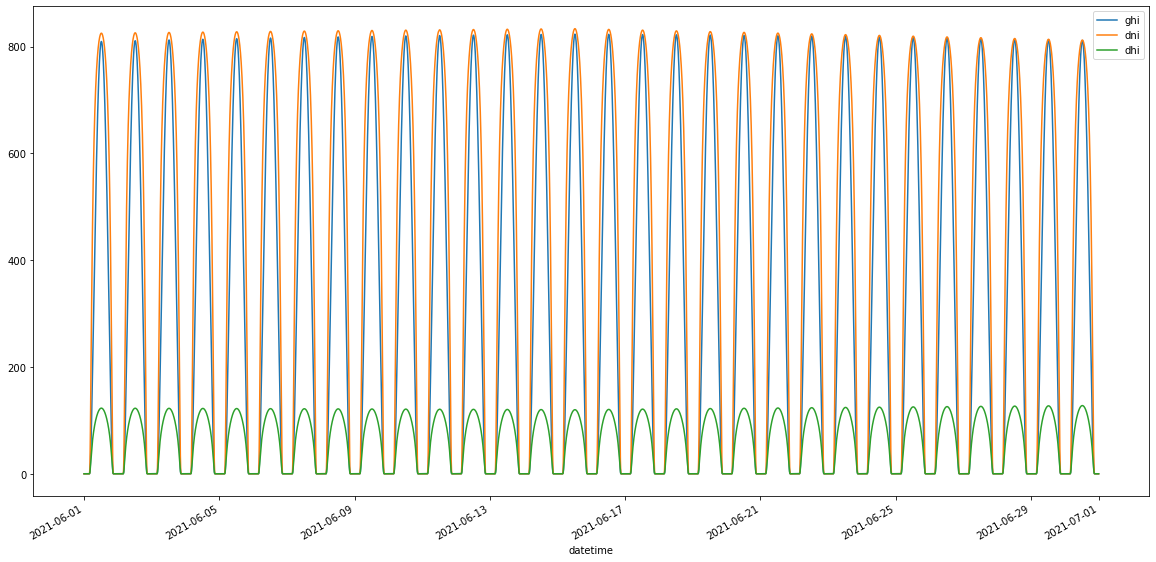

In [55]:
clearsky.plot();

In [56]:
model_chain.run_model(weather=clearsky)

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: pvwatts_dc
  ac_model: pvwatts_inverter
  aoi_model: no_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

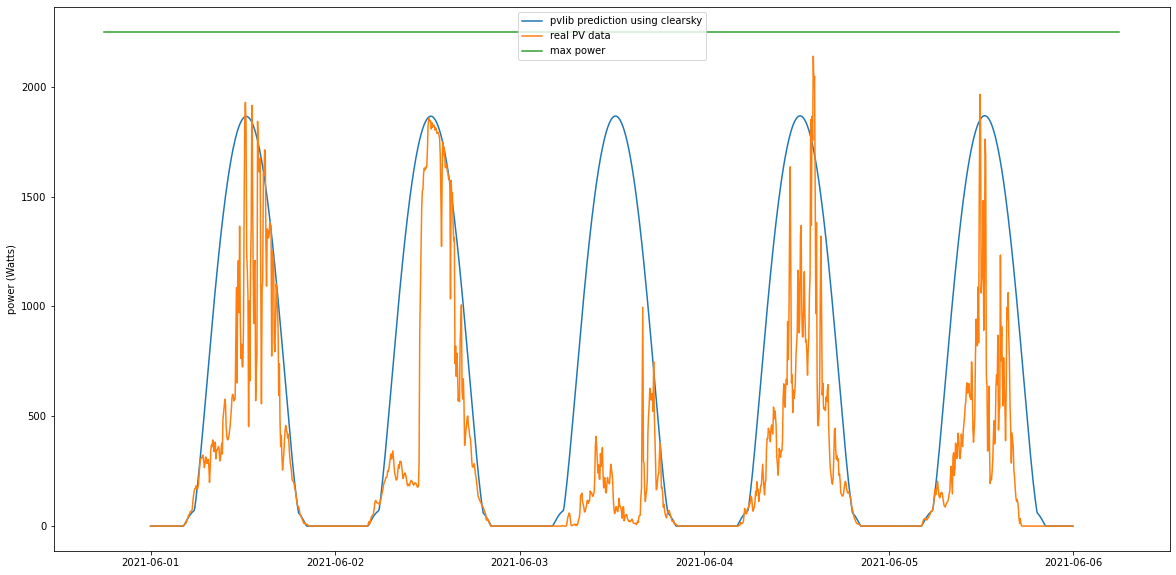

In [57]:
fig, ax = plt.subplots()
DATE = slice("2021-06-01", "2021-06-05")
ax.plot(model_chain.results.ac[DATE], label="pvlib prediction using clearsky")
ax.plot(pv_data_to_forecast[DATE], label="real PV data")
ax.plot(ax.get_xlim(), (power_watts, power_watts), label="max power")
ax.legend()
ax.set_ylabel("power (Watts)");

## Open and prepare NWP data

In [58]:
lat_lon_to_osgb = pyproj.Transformer.from_crs(crs_from=WGS84_EPSG, crs_to=OSGB_EPSG).transform

In [59]:
pv_x_location_osgb, pv_y_location_osgb = lat_lon_to_osgb(
    metadata_for_pv_system.latitude,
    metadata_for_pv_system.longitude,
)

In [60]:
nwp = xr.open_dataset(NWP_ZARR_PATH, engine="zarr", mode="r")
nwp

<xarray.Dataset>
Dimensions:    (variable: 17, init_time: 5319, step: 37, y: 704, x: 548)
Coordinates:
  * init_time  (init_time) datetime64[ns] 2020-01-01 ... 2021-11-08T15:00:00
  * step       (step) timedelta64[ns] 00:00:00 01:00:00 ... 1 days 12:00:00
  * variable   (variable) <U6 'cdcb' 'lcc' 'mcc' ... 'wdir10' 'prmsl' 'prate'
  * x          (x) int64 -239000 -237000 -235000 ... 851000 853000 855000
  * y          (y) int64 1223000 1221000 1219000 ... -179000 -181000 -183000
Data variables:
    UKV        (variable, init_time, step, y, x) float32 ...

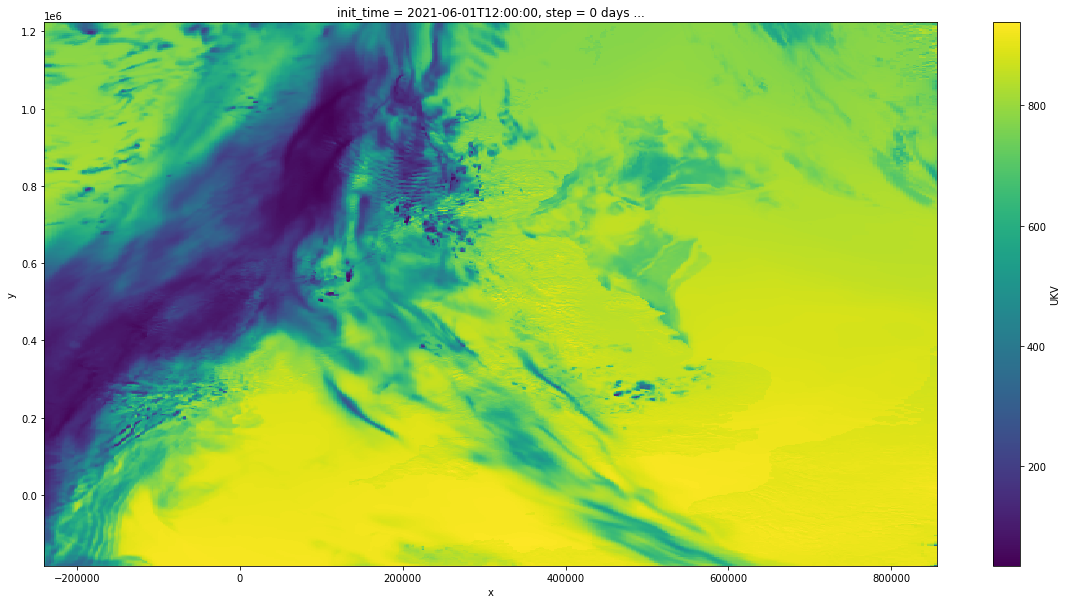

In [61]:
nwp["UKV"].sel(init_time="2021-06-01 12:00", variable="dswrf", step=np.timedelta64(0)).plot();

In [62]:
init_times = pv_data_to_forecast.index.floor("3H").unique()

nwp_selected = nwp["UKV"].sel(
    x=pv_x_location_osgb,
    y=pv_y_location_osgb,
    method="nearest",    
).sel(
    init_time=init_times,
    step=slice(
        np.timedelta64(0, "h"), 
        np.timedelta64(6, "h")
        ),
)

In [64]:
# Find unique values

nwp_df = nwp_selected.stack(target_time=("init_time", "step")).T.to_pandas().reset_index()

In [65]:
nwp_df["target_time"] = nwp_df["init_time"] + nwp_df["step"]
nwp_df = nwp_df.sort_values(["target_time", "init_time", "step"]).drop_duplicates(subset="target_time", keep="first")
nwp_df = nwp_df.drop(columns=["init_time", "step"]).set_index("target_time")

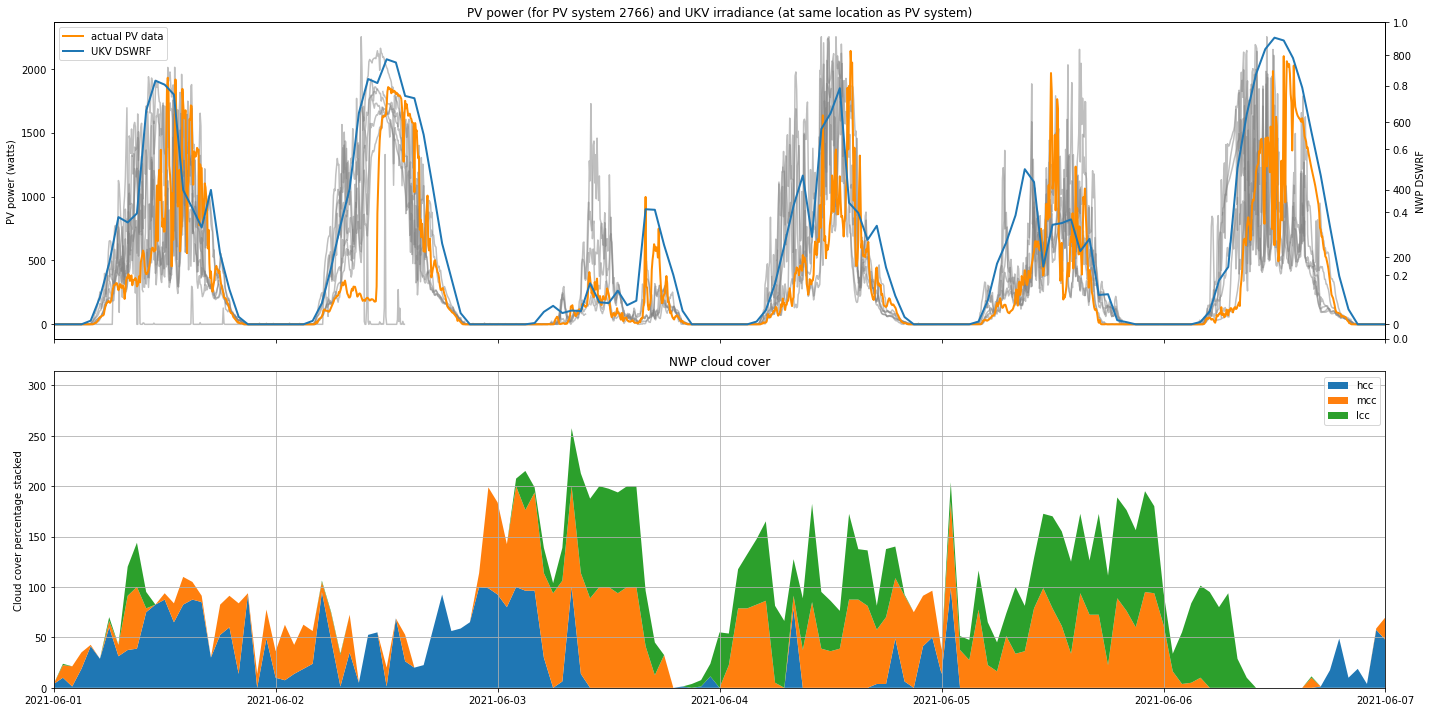

In [72]:
fig, axes = plt.subplots(nrows=2, sharex=True)

ax = axes[0]
ax.plot(
    (
        pv_data_for_nearby_systems.loc[pv_data_to_forecast.index] / 
        pv_data_for_nearby_systems.loc[pv_data_to_forecast.index].max()
        ) * power_watts,
    color="grey",
    alpha=0.5,
)
line1, = ax.plot(pv_data_to_forecast, label="actual PV data", linewidth=2, alpha=1, color="darkorange")
ax.set_ylabel("PV power (watts)")
ax2 = ax.twinx()
line2, = ax2.plot(nwp_df["dswrf"], label="UKV DSWRF", linewidth=2)
ax2.set_ylabel("NWP DSWRF")
ax3 = ax.twinx()
ax.legend(handles=[line1, line2])
ax.set_title(f"PV power (for PV system {pv_system_id}) and UKV irradiance (at same location as PV system)")
ax.set_xlim(
    mdates.datestr2num("2021-06-01"),
    mdates.datestr2num("2021-06-07")
)

ax = axes[1]
CLOUD_VAR_NAMES = ["hcc", "mcc", "lcc"]
ax.stackplot(
    nwp_df.index,
    *[nwp_df[col_name].values[np.newaxis, :] for col_name in CLOUD_VAR_NAMES],
    labels=CLOUD_VAR_NAMES,
)
ax.legend()
ax.set_title("NWP cloud cover")
ax.set_ylabel("Cloud cover percentage stacked")
ax.grid()

fig.tight_layout()

In [122]:
# Use give NWP to pvlib:
# First step, compute GHI, DNI and DHI from cloud cover, as per
# https://pvlib-python.readthedocs.io/en/stable/forecasts.html#cloud-cover-and-radiation
from pvlib.irradiance import disc

total_cloud_cover = nwp_df[["lcc", "mcc", "hcc"]].max(axis="columns") / 100
total_cloud_cover = total_cloud_cover.resample("5T").interpolate(method="linear", limit=12)
solpos = pv_location.get_solarposition(total_cloud_cover.index)
# OFFSET and cloud cover in decimal units here
# larson et. al. use OFFSET = 0.35
OFFSET = 0.35
#ghi = (OFFSET + (1 - OFFSET) * (1 - total_cloud_cover)) * clearsky.ghi
ghi = nwp_df["dswrf"].resample("5T").interpolate(method="linear", limit=12)
dni = disc(ghi, solpos['zenith'], total_cloud_cover.index)['dni']
dhi = ghi - dni * np.cos(np.radians(solpos['zenith']))


irradiance = pd.DataFrame({
    "ghi": ghi,
    "dni": dni,
    "dhi": dhi,
})

(18779.0, 18784.0)

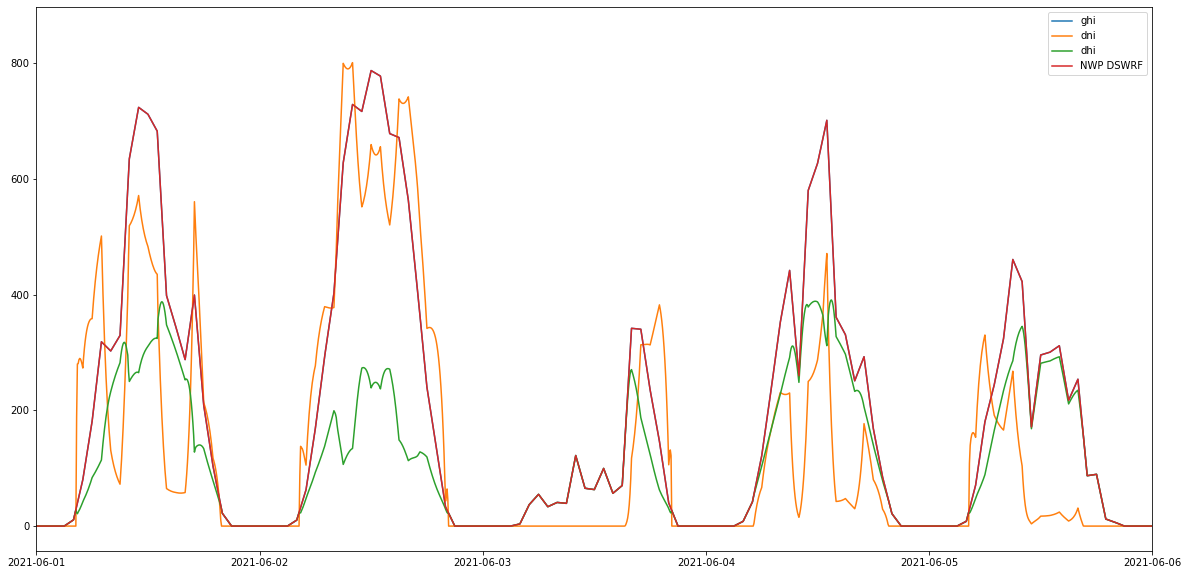

In [123]:
fig, ax = plt.subplots()

ax.plot(irradiance, label=irradiance.columns);
ax.plot(nwp_df["dswrf"], label="NWP DSWRF")
ax.legend()
ax.set_xlim(
    mdates.datestr2num("2021-06-01"),
    mdates.datestr2num("2021-06-06")
)

In [ ]:
# NEXT STEPS:
# Produce PV power forecasts using pvlib. Compare using ghi = nwp_df["dswrf"] vs ghi = (OFFSET... etc.
# on the effect it has on the power forecast.